In [1]:
#@title Step 1: Importing the necessary libraries
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pickle
import time
import itertools
import os

In [ ]:
#@title Step 2: Load preprocessed (sequenced) data; Splitting data into training and testing datasets

import pickle

# Load sequences and vehicle IDs from a file
with open('sequences_vehicle_ids.pkl', 'rb') as f:
#with open('sequences_vehicle_ids.pkl', 'rb') as f:
    sequences, vehicle_ids = pickle.load(f)

# Split data into training and testing
train_size = int(0.8 * len(sequences))
train_sequences = sequences[:train_size]
test_sequences = sequences[train_size:]
train_vehicle_ids = vehicle_ids[:train_size]
test_vehicle_ids = vehicle_ids[train_size:]

class VehicleDataset(Dataset):
    def __init__(self, sequences, flatten=False):
        self.sequences = sequences
        self.flatten = flatten # new

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq, target = self.sequences[idx]
        seq_tensor = torch.Tensor(seq)
        if self.flatten:
            seq_tensor = seq_tensor.view(-1)  # Flatten the sequence
        return seq_tensor, torch.Tensor(target)

# Create DataLoader objects for the full dataset
train_dataset_all = VehicleDataset(train_sequences, flatten=False)
test_dataset_all = VehicleDataset(test_sequences, flatten=False)

train_loader_all = DataLoader(train_dataset_all, batch_size=32, shuffle=True)
test_loader_all = DataLoader(test_dataset_all, batch_size=32, shuffle=False)

# Split train dataset for hyperparameter tuning
tune_size = int(0.2 * len(train_sequences))  # Use 10% of the training data for tuning
tune_sequences = train_sequences[:tune_size]
tune_vehicle_ids = train_vehicle_ids[:tune_size]

tune_dataset = VehicleDataset(tune_sequences, flatten=False)
tune_test_size = int(0.2 * len(test_sequences))  # Use 10% of the testing data for tuning
tune_test_sequences = test_sequences[:tune_test_size]

tune_test_dataset = VehicleDataset(tune_test_sequences, flatten=False)

# Create DataLoader objects for tuning set
train_loader = DataLoader(tune_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(tune_test_dataset, batch_size=32, shuffle=False)

In [ ]:
#@title Step 3: Defining the methods (architecture of NN layers and activation functions)

#### Step 3a: Define the Long Short-Term Memory (LSTM) model

import torch.nn as nn
import torch.nn.functional as F

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

#### Step 3b: Define the Gated Recurrent Unit (GRU) model

class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        out = self.fc(out[:, -1, :])
        return out


#### Step 3c: Define the generic Recurrent Neural Network (RNN) model

class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out


#### Step 3d: Define 1-d CNN (Conv1D) model

class Conv1DModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(Conv1DModel, self).__init__()
        self.conv_layers = nn.ModuleList()
        self.pool_layers = nn.ModuleList()

        # Input layer
        self.conv_layers.append(nn.Conv1d(input_size, hidden_size, kernel_size=3, padding=1))
        self.pool_layers.append(nn.MaxPool1d(kernel_size=2, stride=1))  # Reduced stride

        # Hidden layers
        for _ in range(1, num_layers):
            self.conv_layers.append(nn.Conv1d(hidden_size, hidden_size, kernel_size=3, padding=1))
            self.pool_layers.append(nn.MaxPool1d(kernel_size=2, stride=1))  # Reduced stride

        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.transpose(1, 2)  # Swap dimensions to fit Conv1d input format
        for conv, pool in zip(self.conv_layers, self.pool_layers):
            x = F.relu(conv(x))
            x = pool(x)
        x = x.mean(dim=2)  # Global average pooling
        x = self.fc(x)
        return x
    
#### Step 3e: Define a simple Multi-layer Perceptron (MLP) model

class MLPModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(MLPModel, self).__init__()
        layers = [nn.Linear(input_size, hidden_size), nn.ReLU()]

        for _ in range(1, num_layers):
            layers.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])

        layers.append(nn.Linear(hidden_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x.view(x.size(0), -1))

In [ ]:
#@title Step 4: Training method (generic for all baselines)

def train_model(model, train_loader, criterion, optimizer, num_epochs=10, device='cuda', early_stopping_rounds=4, min_delta=0.01):
    model.to(device)
    epoch_times = []
    epoch_losses = []

    for epoch in range(num_epochs):
        start_time = time.time()
        model.train()
        total_loss = 0
        for sequences, targets in train_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        average_loss = total_loss / len(train_loader)
        epoch_time = time.time() - start_time
        epoch_times.append(epoch_time)
        epoch_losses.append(average_loss)
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.8f}, Time: {epoch_time:.2f}s')

        # Early stopping mechanism
        if epoch >= early_stopping_rounds:
          recent_losses = epoch_losses[-early_stopping_rounds:]
          if all(abs(recent_losses[i] - recent_losses[i-1]) < min_delta * recent_losses[i-1] for i in range(1, early_stopping_rounds)):
              print(f"Early stopping at epoch {epoch+1}")
              break

    return epoch_times, epoch_losses

In [ ]:
#@title Step 5: Model Evaluation

from sklearn.metrics import mean_absolute_error, r2_score

def evaluate_model(model, test_loader, device='cuda'):
    # device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model.to(device)

    model.eval()
    predictions = []
    actuals = []

    with torch.no_grad():
        for sequences, targets in test_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            outputs = model(sequences)
            predictions.extend(outputs.cpu().numpy())
            actuals.extend(targets.cpu().numpy())

    predictions = np.array(predictions)
    actuals = np.array(actuals)

    rmse = np.sqrt(np.mean((predictions - actuals) ** 2))
    mae = mean_absolute_error(actuals, predictions)
    r2 = r2_score(actuals, predictions)

    print(f'RMSE: {rmse:.8f}')
    print(f'MAE: {mae:.8f}')
    print(f'R2 Score: {r2:.8f}')

    return predictions, actuals, rmse, mae, r2

In [ ]:
import torch

print(torch.cuda.is_available())
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU available")
print(torch.__version__)
print(torch.version.cuda)


In [ ]:
#@title Step 6: Define a method to run the training and evaluation of the model for different sets of hyperparameters

def run_experiment(params, input_size=4, output_size=2, model_type='LSTM'):
    hidden_size, num_layers, learning_rate, num_epochs = params

    if model_type == 'LSTM':
        model = LSTMModel(input_size, hidden_size, num_layers, output_size)
        save_path = 'experiment_results_LSTM.csv'
    elif model_type == 'GRU':
        model = GRUModel(input_size, hidden_size, num_layers, output_size)
        save_path = 'experiment_results_GRU.csv'
    elif model_type == 'RNN':
        model = RNNModel(input_size, hidden_size, num_layers, output_size)
        save_path = 'experiment_results_RNN.csv'
    elif model_type == 'Conv1D':
        model = Conv1DModel(input_size, hidden_size, num_layers, output_size)
        save_path = 'experiment_results_Conv1D.csv'
    elif model_type == 'MLP':
        example_input, _ = next(iter(train_loader))
        flattened_input_size = example_input.view(example_input.size(0), -1).size(1)
        model = MLPModel(flattened_input_size, hidden_size, num_layers, output_size)
        save_path = 'experiment_results_MLP.csv'
    else:
        raise ValueError(f"Unsupported model type: {model_type}")

    # Initialize criterion and optimizer
    criterion = nn.MSELoss() # mean squared error (MSE) is the criterion for evaluating loss in each epoch
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Using Adam optimizer

    # Train the model and measure time
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    # Use the provided train_model function
    epoch_times, epoch_losses = train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs, device=device)

    # Evaluate the model
    predictions, actuals, rmse, mae, r2 = evaluate_model(model, test_loader, device=device)

    # Calculate average epoch time
    avg_epoch_time = np.mean(epoch_times)

    result = {
        'hidden_size': hidden_size,
        'num_layers': num_layers,
        'learning_rate': learning_rate,
        'num_epochs': num_epochs,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'avg_epoch_time': avg_epoch_time,
        'epoch_losses': epoch_losses
    }

    results_df = pd.DataFrame([result])
    if save_path:
        if os.path.exists(save_path):
            results_df.to_csv(save_path, mode='a', header=False, index=False)
        else:
            results_df.to_csv(save_path, index=False)

    return result


In [ ]:
#@title Step 7: Define hyperparameter sets

# Define the hyperparameter grid (2*3*8*1 = 48 total possibilities)
param_grid = {
    'hidden_size': [50, 100],
    'num_layers': [2, 3, 4],
    'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001, 0.00005],
    'num_epochs': [30] 
}

# Create a list of hyperparameter combinations
param_combinations = list(itertools.product(
    param_grid['hidden_size'],
    param_grid['num_layers'],
    param_grid['learning_rate'],
    param_grid['num_epochs']
))

def run_specific_experiment(index, input_size=4, output_size=2, model_type='LSTM'): # allowed number for index: 0-47
    if index < 0 or index >= len(param_combinations):
        raise ValueError("Index out of range")
    
    params = param_combinations[index]

    print('model type: ', model_type)
    print('index of experiment / total number of experiments: ', str(index+1), ' / ',str(len(param_combinations)))
    print('Hyperparameters set (hidden_size, num_layers, learning_rate, num_epochs): ', params)

    result = run_experiment(params, input_size, output_size, model_type)
    
    return result

In [ ]:
#@title Step 8: Execute each method (flexible for continuing unfinished experiments)

# We have 48 sets of experiments due to the different values for hyperparameters in param_grid (defined in Step 7)
for i in range(48):
    result = run_specific_experiment(index=i, model_type='LSTM')
    print('---------')
for i in range(48):
    result = run_specific_experiment(index=i, model_type='GRU')
    print('---------')
for i in range(48):
    result = run_specific_experiment(index=i, model_type='RNN')
    print('---------')
for i in range(48): 
    result = run_specific_experiment(index=i, model_type='Conv1D')
    print('---------')
for i in range(48):
    result = run_specific_experiment(index=i, model_type='MLP')
    print('---------')

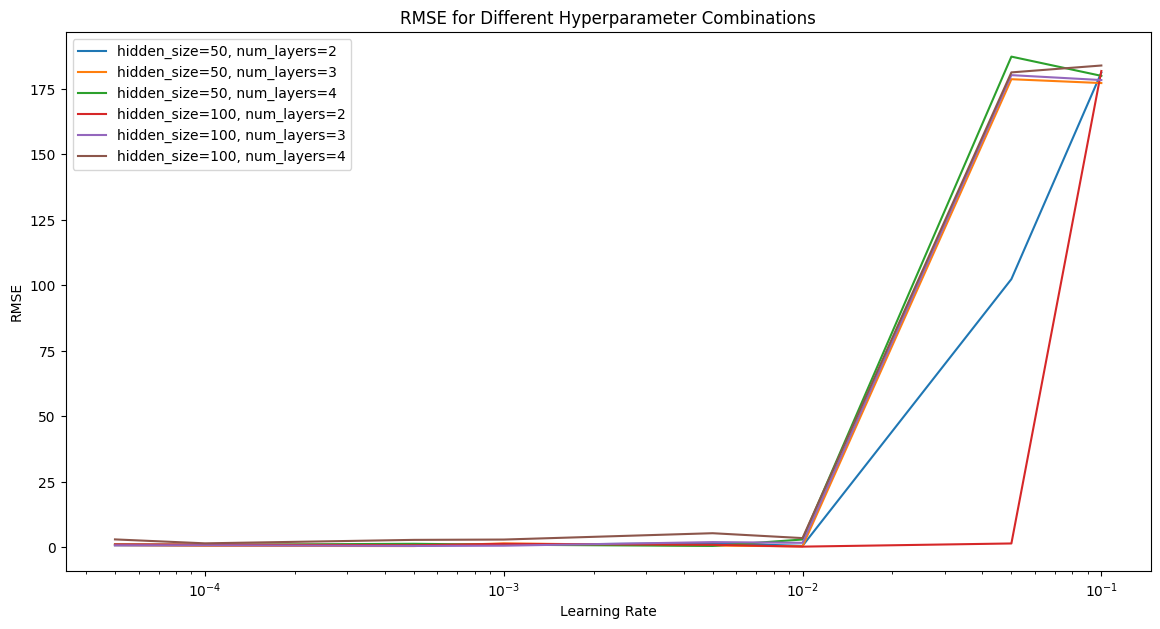

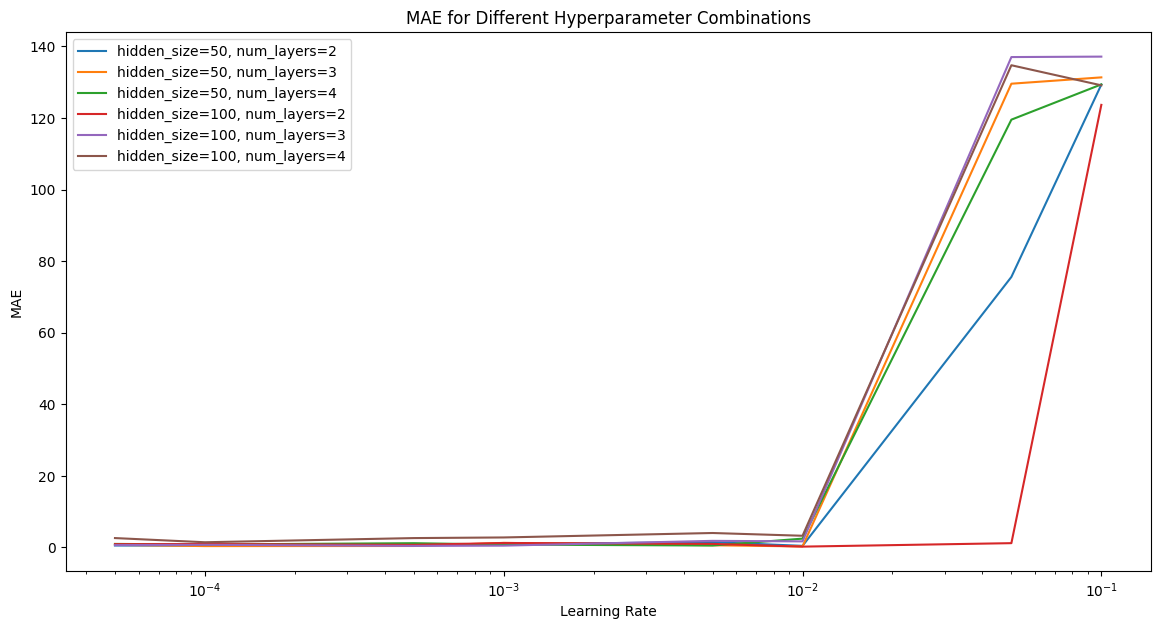

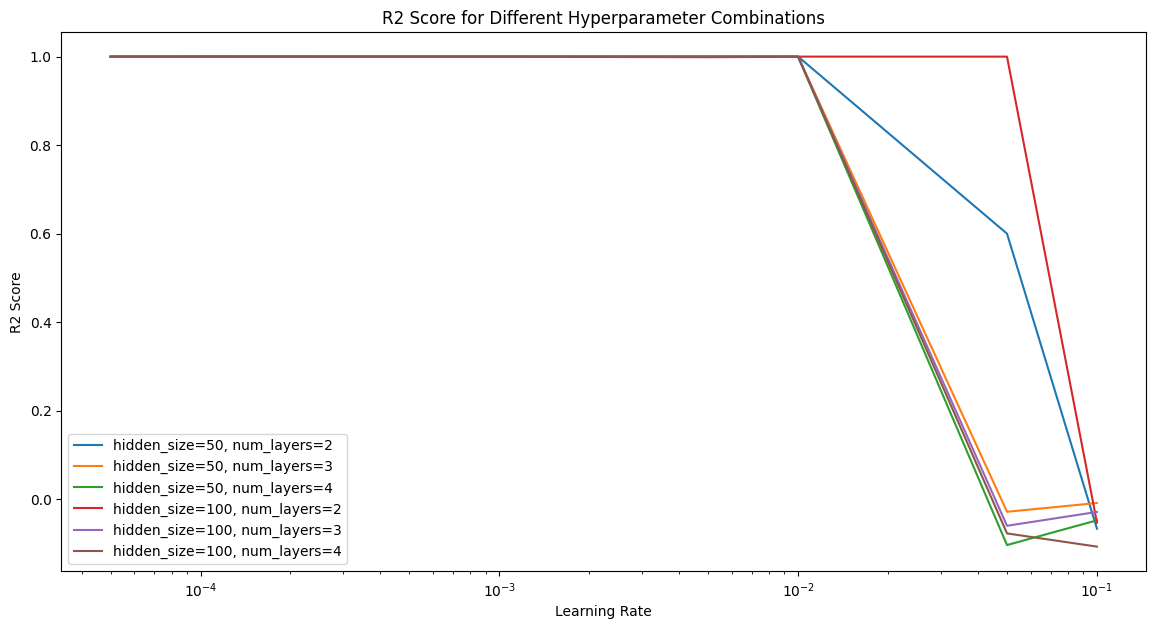

In [105]:
#@title Step 9a: Visualize Results to evalate different hyperparameters
import matplotlib.pyplot as plt

save_path = 'experiment_results_Conv1D.csv' # change LSTM with other methods to visualize metrics for those methods (Methods: RNN, GRU, LSTM, Conv1D, MLP)
results_df = pd.read_csv(save_path)

# Plot RMSE for different hyperparameters
plt.figure(figsize=(14, 7))
for key, grp in results_df.groupby(['hidden_size', 'num_layers']):
    plt.plot(grp['learning_rate'], grp['rmse'], label=f"hidden_size={key[0]}, num_layers={key[1]}")
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')
plt.xscale('log')
plt.title('RMSE for Different Hyperparameter Combinations')
plt.legend()
plt.show()

# Plot MAE for different hyperparameters
plt.figure(figsize=(14, 7))
for key, grp in results_df.groupby(['hidden_size', 'num_layers']):
    plt.plot(grp['learning_rate'], grp['mae'], label=f"hidden_size={key[0]}, num_layers={key[1]}")
plt.xlabel('Learning Rate')
plt.ylabel('MAE')
plt.xscale('log')
plt.title('MAE for Different Hyperparameter Combinations')
plt.legend()
plt.show()

# Plot R2 Score for different hyperparameters
plt.figure(figsize=(14, 7))
for key, grp in results_df.groupby(['hidden_size', 'num_layers']):
    plt.plot(grp['learning_rate'], grp['r2'], label=f"hidden_size={key[0]}, num_layers={key[1]}")
plt.xlabel('Learning Rate')
plt.ylabel('R2 Score')
plt.xscale('log')
plt.title('R2 Score for Different Hyperparameter Combinations')
plt.legend()
plt.show()




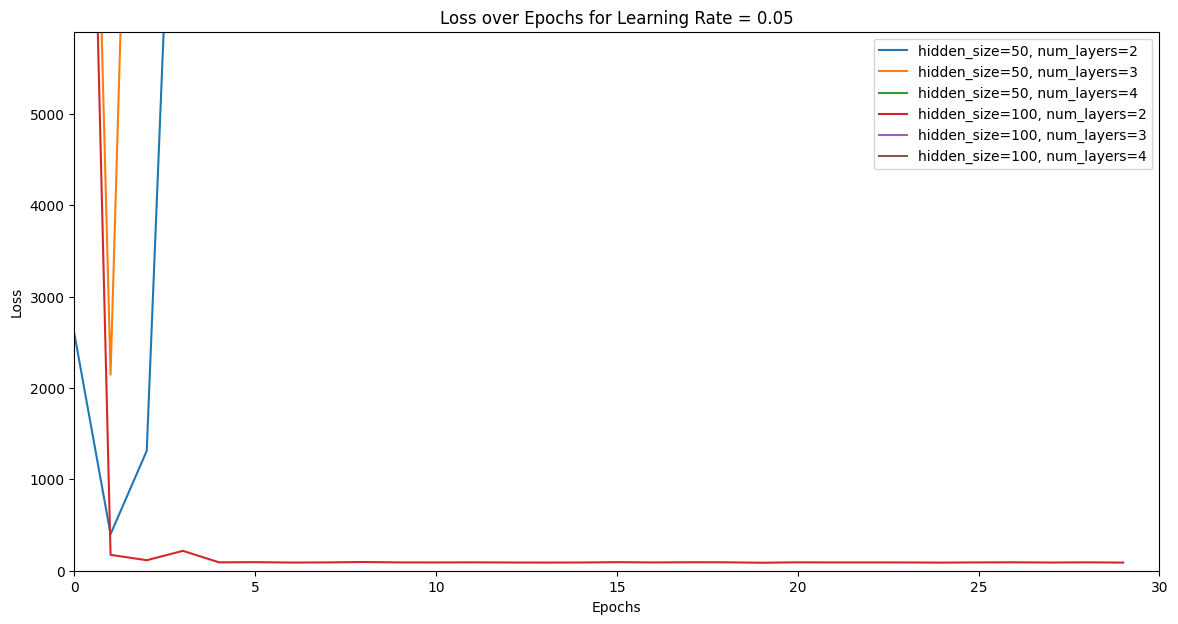

In [131]:
#@title Step 9b: Visualize Results to evalate different hyperparameters

# Plot loss over epochs for different hyperparameters
# plt.figure(figsize=(14, 7))
# for idx, result in results_df.iterrows():
#     epoch_losses = eval(result['epoch_losses'])  # Convert string representation of list back to list
#     plt.plot(epoch_losses, label=f"hidden_size={result['hidden_size']}, num_layers={result['num_layers']}, lr={result['learning_rate']}, epochs={result['num_epochs']}")
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.title('Loss over Epochs for Different Hyperparameter Combinations')
# plt.legend()
# plt.show()

# Define the specific learning rate you want to plot
specific_learning_rate = 0.05

# Filter the DataFrame to include only rows with the specific learning rate
filtered_df = results_df[results_df['learning_rate'] == specific_learning_rate]

# Plot loss over epochs for the filtered hyperparameter combinations
plt.figure(figsize=(14, 7))

for idx, result in filtered_df.iterrows():
    epoch_losses = eval(result['epoch_losses'])  # Convert string representation of list back to list
    plt.plot(epoch_losses, label=f"hidden_size={result['hidden_size']}, num_layers={result['num_layers']}")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 100)
plt.xlim(0, 30)
plt.title(f'Loss over Epochs for Learning Rate = {specific_learning_rate}')
plt.legend()
plt.show()


In [141]:


# Methods to analyze
methods = ["GRU", "LSTM", "RNN", "Conv1D", "MLP"]

# Function to calculate the loss slope (rate of convergence)
def calculate_loss_slope(losses):
    if isinstance(losses, str):
        losses = eval(losses)  # Convert string representation of list back to list
    # Fit a linear model to the loss data (epochs vs loss)
    epochs = np.arange(1, len(losses) + 1)
    slope, _ = np.polyfit(epochs, losses, 1)
    return slope  # Slope of the loss curve

# Function to rank and select the top 3 experiments
def select_top_experiments(df, epoch_time_weight=0.1):
    # Rank based on RMSE (lower is better)
    df['rank_rmse'] = df['rmse'].rank(ascending=True)
    # Rank based on MAE (lower is better)
    df['rank_mae'] = df['mae'].rank(ascending=True)
    # Rank based on R2 (higher is better)
    df['rank_r2'] = df['r2'].rank(ascending=False)
    # Normalize avg_epoch_time to a 0-1 scale
    df['norm_epoch_time'] = (df['avg_epoch_time'] - df['avg_epoch_time'].min()) / (df['avg_epoch_time'].max() - df['avg_epoch_time'].min())
    # Apply a weight to the normalized epoch time
    df['weighted_epoch_time'] = df['norm_epoch_time'] * epoch_time_weight
    # Calculate and rank based on loss slope (more negative slope is better)
    df['loss_slope'] = df['epoch_losses'].apply(calculate_loss_slope)
    df['rank_loss_slope'] = df['loss_slope'].rank(ascending=True) / 10
    
    # Sum the ranks to get a combined score
    df['combined_rank'] = (df['rank_rmse'] + df['rank_mae'] + df['rank_r2'] +
                           df['weighted_epoch_time'] + df['rank_loss_slope'])
    
    # Sort by the combined rank and select the top 3
    top_experiments = df.sort_values('combined_rank').head(10)
    
    return top_experiments
# Dictionary to store results
results = {}

# Iterate over each method and process the corresponding file
for method in methods:
    filepath = f'experiment_results_{method}.csv'
    
    if os.path.exists(filepath):
        df = pd.read_csv(filepath)
        top_experiments = select_top_experiments(df)
        results[method] = top_experiments
    else:
        print(f"File {filepath} not found in the directory.")

# Display the results for each method
for method, top_experiments in results.items():
    print(f"Top 3 experiments for {method}:")
    display(top_experiments)
    print("\n")

# Saving the best results to new CSV files
for method, top_experiments in results.items():
    top_experiments.to_csv(f'top_3_experiments_{method}.csv', index=False)


Top 3 experiments for GRU:


,hidden_size,num_layers,learning_rate,num_epochs,rmse,mae,r2,avg_epoch_time,epoch_losses,rank_rmse,rank_mae,rank_r2,norm_epoch_time,weighted_epoch_time,loss_slope,rank_loss_slope,combined_rank
37,100,3,0.0005,30,10.677146,6.838010,0.996168,22.883705,"[1140825.723517672, 623556.2029672147, 302359....",1.0,1.0,1.0,0.738325,0.073832,-13803.364221,3.0,6.073832
29,100,2,0.0005,30,14.428996,10.812167,0.993252,21.954699,"[1140698.1336909798, 623318.1916578534, 302346...",2.0,3.0,2.0,0.560249,0.056025,-13685.095352,3.2,10.256025
12,50,3,0.0010,30,16.683578,10.710158,0.990130,21.160818,"[1140335.3430591566, 619464.186335801, 297491....",3.0,2.0,3.0,0.408075,0.040808,-13938.911818,2.9,10.940808
5,50,2,0.0005,30,18.867533,12.558653,0.987097,19.031920,"[1301044.6717129503, 972521.965696643, 710582....",5.0,4.0,5.0,0.000000,0.000000,-24405.941950,2.4,16.400000
36,100,3,0.0010,30,17.805304,13.576498,0.987773,22.853377,"[889650.8369012692, 226880.09897610193, 43336....",4.0,5.0,4.0,0.732511,0.073251,-7516.895678,3.9,16.973251
4,50,2,0.0010,30,21.080359,13.618332,0.985243,19.069798,"[1139491.0502524562, 618830.6009441526, 297106...",6.0,6.0,6.0,0.007261,0.000726,-13753.693086,3.1,21.100726
13,50,3,0.0005,30,26.779861,16.410572,0.978366,21.021261,"[1301090.215338428, 972597.1168292849, 710696....",8.0,7.0,7.0,0.381324,0.038132,-24364.723046,2.5,24.538132
28,100,2,0.0010,30,24.311530,18.007822,0.978053,22.319239,"[889878.5146910822, 226983.9667830155, 41052.6...",7.0,8.0,8.0,0.630126,0.063013,-7530.685235,3.8,26.863013
44,100,4,0.0010,30,136.990780,90.110150,0.477103,24.248846,"[890974.3986635166, 227545.55616993466, 43387....",10.0,9.0,9.0,1.000000,0.100000,-7571.650207,3.7,31.800000
20,50,4,0.0010,30,133.577180,91.000320,0.464598,22.547544,"[1140659.9433252593, 619813.9580078125, 297817...",9.0,10.0,10.0,0.673888,0.067389,-13565.497500,3.3,32.367389




Top 3 experiments for LSTM:


,hidden_size,num_layers,learning_rate,num_epochs,rmse,mae,r2,avg_epoch_time,epoch_losses,rank_rmse,rank_mae,rank_r2,norm_epoch_time,weighted_epoch_time,loss_slope,rank_loss_slope,combined_rank
45,100,4,0.0005,30,10.802510,6.682327,0.995892,23.686289,"[1138733.7401832014, 622094.5364824986, 301534...",2.0,1.0,1.0,0.984576,0.098458,-13831.960699,3.1,7.198458
29,100,2,0.0005,30,10.757427,7.302156,0.995611,20.525925,"[1137920.7277480213, 621599.9580547216, 301137...",1.0,2.0,2.0,0.196896,0.019690,-13693.504367,3.5,8.519690
28,100,2,0.0010,30,12.489048,8.393791,0.994678,20.386667,"[886613.1514098322, 225806.8042141444, 40056.7...",3.0,3.0,3.0,0.162188,0.016219,-7430.993478,4.5,13.516219
36,100,3,0.0010,30,15.917845,11.748438,0.990011,22.022468,"[888594.7436118313, 226521.305916199, 43256.73...",4.0,4.0,4.0,0.569890,0.056989,-7745.706492,4.4,16.456989
4,50,2,0.0010,30,17.497690,13.382112,0.988951,19.847994,"[1137526.6136650518, 617718.0414889806, 296504...",5.0,6.0,5.0,0.027930,0.002793,-13725.813884,3.4,19.402793
37,100,3,0.0005,30,19.066093,12.317503,0.987819,21.988051,"[1138635.1572990585, 622030.7795484784, 301533...",6.0,5.0,6.0,0.561312,0.056131,-13784.537977,3.2,20.256131
12,50,3,0.0010,30,25.202870,15.872816,0.974616,21.330674,"[1136560.9695687774, 617129.80584317, 296077.6...",7.0,7.0,7.0,0.397469,0.039747,-13754.156485,3.3,24.339747
44,100,4,0.0010,30,57.235516,41.053410,0.865129,23.631506,"[888621.0104522039, 226612.93932412492, 43257....",8.0,8.0,8.0,0.970922,0.097092,-8334.260538,4.3,28.397092
33,100,3,0.0500,30,180.548070,127.363110,-0.049959,22.117513,"[79711.70993081972, 35886.61734395256, 35888.9...",16.0,10.0,13.0,0.593579,0.059358,-8764.970026,4.2,43.259358
16,50,4,0.1000,30,180.515700,128.517030,-0.053175,21.330266,"[80403.44149966844, 35900.50266289191, 35887.6...",14.0,20.0,15.0,0.397368,0.039737,-8903.220747,3.9,52.939737




Top 3 experiments for RNN:


,hidden_size,num_layers,learning_rate,num_epochs,rmse,mae,r2,avg_epoch_time,epoch_losses,rank_rmse,rank_mae,rank_r2,norm_epoch_time,weighted_epoch_time,loss_slope,rank_loss_slope,combined_rank
29,100,2,0.0005,30,16.258429,11.051031,0.988963,18.116080,"[1142544.0048273744, 624526.601443095, 302998....",1.0,1.0,1.0,0.010676,0.001068,-13770.315088,3.5,6.501068
28,100,2,0.0010,30,59.520080,41.629898,0.871212,18.246114,"[891363.4259560931, 227571.66610784407, 40707....",2.0,2.0,2.0,0.048301,0.004830,-7377.245085,3.9,9.904830
25,100,2,0.0500,30,180.513570,126.687190,-0.046982,18.196215,"[59903.988529122034, 35923.78601913785, 35920....",6.0,5.0,3.0,0.033863,0.003386,-4793.768383,4.1,18.103386
19,50,4,0.0050,30,180.516070,128.517410,-0.053191,20.433915,"[476192.5713935419, 36901.7698874661, 35846.13...",7.0,23.0,6.0,0.681336,0.068134,-62996.214013,1.3,37.368134
27,100,2,0.0050,30,180.708530,128.553680,-0.056369,18.143835,"[266329.4240614712, 35848.94768407563, 35856.9...",10.0,26.0,8.0,0.018707,0.001871,-46094.252084,1.9,45.901871
10,50,3,0.0100,30,180.377820,128.941010,-0.052369,19.768750,"[264505.7965531662, 35854.518218327816, 35851....",4.0,35.0,5.0,0.488872,0.048887,-45731.137128,2.1,46.148887
2,50,2,0.0100,30,180.821840,128.324430,-0.057406,18.242350,"[264456.42791088385, 35857.81178836739, 35849....",16.0,18.0,11.0,0.047212,0.004721,-45721.467314,2.2,47.204721
34,100,3,0.0100,30,179.965440,129.744480,-0.048114,20.233330,"[153990.0923672472, 35858.89287503838, 35862.2...",3.0,37.0,4.0,0.623297,0.062330,-23625.534567,3.3,47.362330
4,50,2,0.0010,30,180.595750,128.779360,-0.055291,18.145708,"[1141718.8965099617, 620539.188288926, 298230....",8.0,34.0,7.0,0.019249,0.001925,-112961.770843,0.3,49.301925
12,50,3,0.0010,30,180.703740,128.659270,-0.056552,19.779482,"[1140430.4040239493, 619710.7201487445, 297734...",9.0,31.0,9.0,0.491978,0.049198,-112815.216936,0.5,49.549198




Top 3 experiments for Conv1D:


,hidden_size,num_layers,learning_rate,num_epochs,rmse,mae,r2,avg_epoch_time,epoch_losses,rank_rmse,rank_mae,rank_r2,norm_epoch_time,weighted_epoch_time,loss_slope,rank_loss_slope,combined_rank
26,100,2,0.0100,30,0.318660,0.224546,0.999996,18.308964,"[680.0118564734292, 71.22375523281084, 45.6952...",1.0,1.0,1.0,0.428092,0.042809,-5.350343,4.3,7.342809
10,50,3,0.0100,30,0.420632,0.275710,0.999995,18.418197,"[1599.3846197728897, 138.09951154570456, 48.87...",2.0,2.0,2.0,0.456540,0.045654,-11.871028,3.2,9.245654
13,50,3,0.0005,30,0.532501,0.403167,0.999991,18.453724,"[3715.559050297047, 16.55730773009132, 10.2897...",3.0,4.0,3.0,0.465793,0.046579,-24.208309,2.3,12.346579
37,100,3,0.0005,30,0.578271,0.421838,0.999988,19.499730,"[1919.6696050422486, 22.899426299346587, 16.77...",4.0,5.0,5.0,0.738212,0.073821,-12.766031,3.0,17.073821
14,50,3,0.0001,30,0.623837,0.373458,0.999985,18.437485,"[15143.85223824918, 38.63159645345534, 14.4529...",7.0,3.0,8.0,0.461563,0.046156,-98.059418,1.4,19.446156
2,50,2,0.0100,30,0.607327,0.439697,0.999989,16.684064,"[854.8864052292431, 83.48311792847632, 47.8057...",6.0,6.0,4.0,0.004906,0.000491,-6.499238,4.2,20.200491
19,50,4,0.0050,30,0.587531,0.535914,0.999987,20.462627,"[1452.345444270194, 119.72186193841318, 75.048...",5.0,9.0,6.5,0.988987,0.098899,-11.097671,3.3,23.898899
36,100,3,0.0010,30,0.670745,0.499523,0.999987,19.439162,"[1391.5984573934763, 36.14403049592498, 24.082...",8.0,8.0,6.5,0.722438,0.072244,-9.512749,3.7,26.272244
6,50,2,0.0001,30,0.782237,0.496519,0.999977,16.728456,"[20230.053307635295, 74.73209363703644, 35.547...",10.0,7.0,11.0,0.016468,0.001647,-131.273904,1.2,29.201647
11,50,3,0.0050,30,0.717426,0.601710,0.999982,18.455451,"[1063.7825949358628, 77.87528404373855, 52.035...",9.0,11.0,9.0,0.466243,0.046624,-7.995906,3.8,32.846624




Top 3 experiments for MLP:


,hidden_size,num_layers,learning_rate,num_epochs,rmse,mae,r2,avg_epoch_time,epoch_losses,rank_rmse,rank_mae,rank_r2,norm_epoch_time,weighted_epoch_time,loss_slope,rank_loss_slope,combined_rank
39,100,3,0.00005,30,0.417470,0.227998,0.999993,15.784782,"[32811.94768182413, 55.267583626066234, 16.063...",1.0,1.0,2.0,0.371310,0.037131,-212.139821,1.3,5.337131
4,50,2,0.00100,30,0.450632,0.233360,0.999993,14.268323,"[5716.834132463293, 11.745539777777992, 12.179...",2.0,2.0,1.0,0.000000,0.000000,-37.026827,2.5,7.500000
5,50,2,0.00050,30,0.464033,0.315276,0.999992,14.278799,"[10978.425889338534, 16.009909466567844, 5.291...",3.0,3.0,3.0,0.002565,0.000257,-70.971582,2.1,11.100257
30,100,2,0.00010,30,0.524054,0.357193,0.999988,14.407965,"[16509.936249956685, 27.598385056049672, 7.226...",4.0,4.0,5.0,0.034192,0.003419,-106.753386,2.0,15.003419
6,50,2,0.00010,30,0.525894,0.405011,0.999990,14.303018,"[33932.106995955175, 50.313148681318395, 20.61...",5.0,5.0,4.0,0.008495,0.000850,-219.431318,1.2,15.200850
31,100,2,0.00005,30,0.593245,0.438702,0.999987,14.460661,"[31980.515210745118, 50.600397706877715, 16.47...",6.0,7.0,6.0,0.047095,0.004709,-206.759087,1.5,20.504709
47,100,4,0.00005,30,0.659449,0.428436,0.999985,17.066943,"[29950.84634705968, 37.13306046020256, 11.1158...",7.0,6.0,7.0,0.685251,0.068525,-193.536445,1.7,21.768525
22,50,4,0.00010,30,0.718157,0.530801,0.999985,17.339893,"[29995.268560702625, 49.93993414538266, 25.955...",8.0,9.0,8.0,0.752084,0.075208,-194.097415,1.6,26.675208
15,50,3,0.00005,30,0.733627,0.493614,0.999983,16.676193,"[67184.95965830624, 70.21159998467395, 39.4190...",9.0,8.0,9.0,0.589574,0.058957,-434.268033,1.0,27.058957
7,50,2,0.00005,30,0.736016,0.578286,0.999978,14.390311,"[60728.4627618519, 76.12205454368778, 42.75939...",10.0,11.0,11.0,0.029869,0.002987,-392.638988,1.1,33.102987
